In [6]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import preprocess_dataset as ut
from scipy.interpolate import BSpline
from tfkan import DenseKAN
from tensorflow import keras
from keras_tuner import HyperModel, GridSearch, RandomSearch

In [7]:
x_train = tf.convert_to_tensor(pd.read_csv("datasets/x_train.csv").to_numpy()[:, 1:])
x_train_std = ut.standardize(np.array(x_train))
my_record = x_train_std[0]
print(my_record)

[0.66027397 0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.36040609 0.05736371 0.58352043 0.71772735
 0.01614087 0.64499929 0.49679977 0.71428571 0.64285714 0.4
 0.66849315 0.        ]


$$
\Phi_{l} = 
\begin{bmatrix}
\phi_{11} & \phi_{12} & \cdots & \phi_{1n} \\
\phi_{21} & \phi_{22} & \cdots & \phi_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
\phi_{m1} & \phi_{m2} & \cdots & \phi_{mn}
\end{bmatrix}
$$
Dove 
$$
\phi_{ij} = w_bb(x) + w_s\sum_i{c_iB_i(x)}
$$

[[-8.06453303e-03  6.87398598e-03 -1.74181225e-03  2.36546697e-02
  -7.43341631e-03  3.49469611e-03  5.32364294e-04 -1.64054759e-02
  -2.92431407e-02  9.58579291e-04  5.49455910e-03  1.64162158e-02
  -1.34898555e-02 -2.41912980e-04 -2.65341141e-03  1.87479651e-03
  -2.18839752e-03 -3.83549650e-02  1.05425124e-02  4.61615128e-04
   2.66308716e-02 -1.91407646e-02  4.68271191e-04 -2.71059115e-02
   2.61606740e-02 -2.35385192e-02]
 [-1.27554128e-02 -2.75726560e-02 -5.49531685e-03  6.89852700e-03
   2.10866492e-03  2.03695134e-03 -1.82302479e-03 -3.83579225e-03
  -2.30390453e-02 -1.55210067e-03 -6.34594279e-04  2.18170468e-02
   4.02018906e-02 -9.59770502e-03  1.50718916e-02  5.62542766e-03
   3.48980222e-03  2.61490373e-02 -1.51951342e-02  1.63054533e-02
   6.37088956e-04  2.38936028e-03 -2.07047816e-02 -1.01873324e-02
   3.21767271e-03  1.35203894e-02]
 [-4.83711886e-03 -7.13479632e-03 -2.95487527e-03 -1.38277152e-03
  -3.39574500e-02 -3.67813253e-03  2.83143223e-03  3.98751178e-03
  -1.0

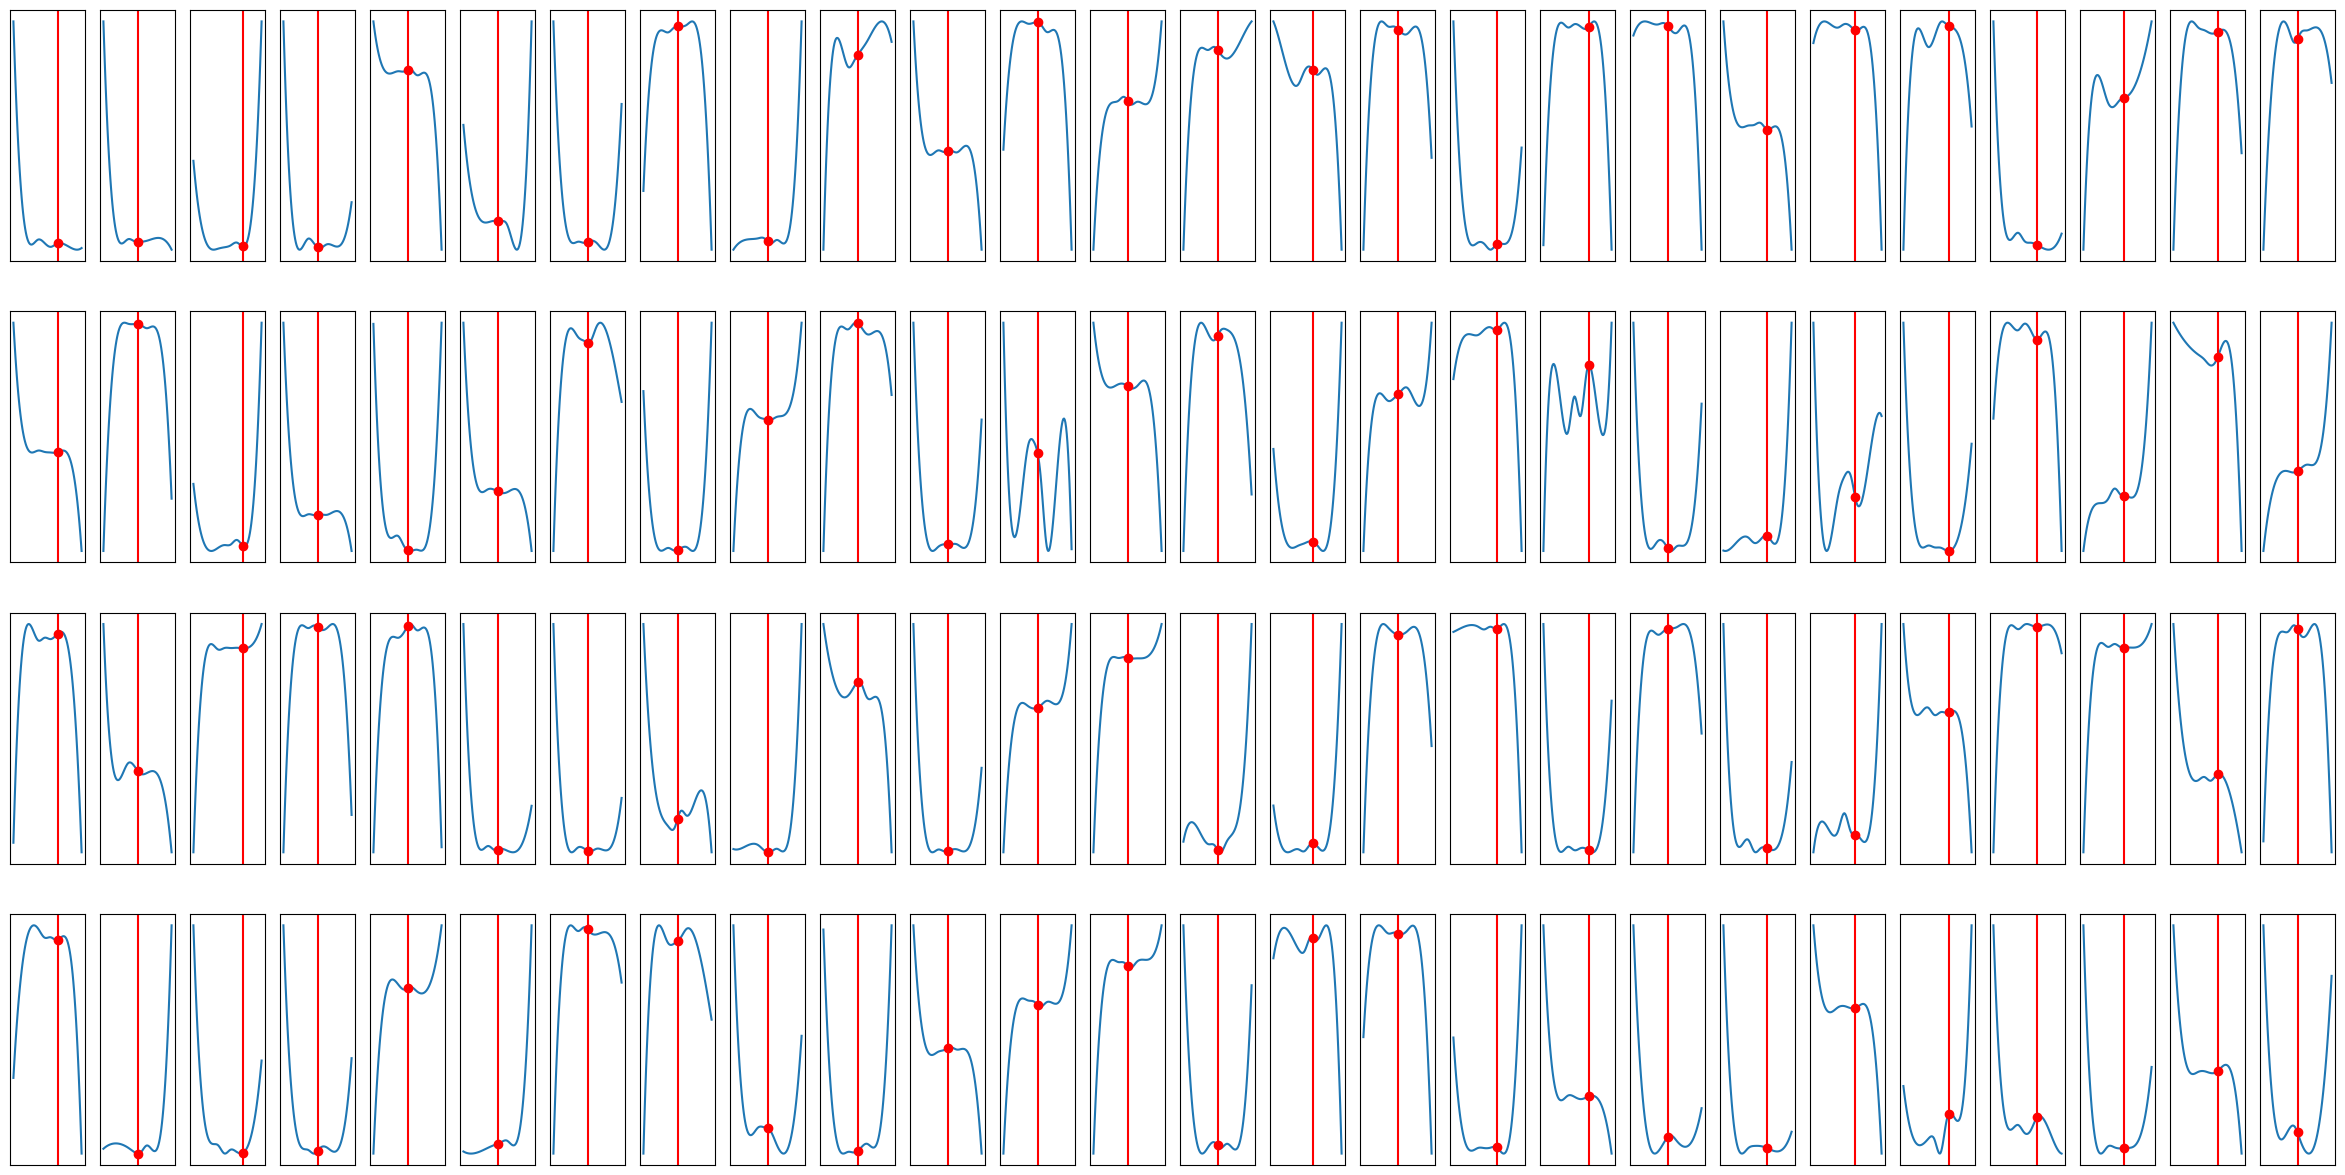

In [8]:
model = tf.keras.models.Sequential([
    DenseKAN(4),
    DenseKAN(1)
])

model.build(input_shape=(None, 26))

spline_list = model.layers[0].spline_list
num_splines = len(spline_list)

nrows = int(model.layers[0].units)
ncols = int(model.layers[0].input_dim)

fig, axes = plt.subplots(nrows, ncols, figsize=(30, 15))
axes = axes.flatten()

w_s = np.array(model.layers[0].scale_factor)
b_act = np.array(model.layers[0].basis_activation(my_record))
b_act = [b_act] * nrows

layer1_matrix = np.zeros(nrows * ncols)

for i, spline in enumerate(spline_list):
    xx = np.linspace(spline.t[0], spline.t[-1], 100)
    yy = spline(xx)
    axes[i].plot(xx, yy)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].axvline(x=my_record[i%26], color='red')
    axes[i].plot(my_record[i%26], spline(my_record[i%26]), 'ro')
    layer1_matrix[i] = spline(my_record[i%26])

layer1_matrix = np.reshape(layer1_matrix, (nrows, ncols))
layer1_matrix = layer1_matrix * w_s.T
print(layer1_matrix)
plt.show()

$$
L_{l}(x) = \sum{\phi_{l-1}(x_0)}
$$

[[ 0.04554463 -0.02156719 -0.01660911  0.07693618]]


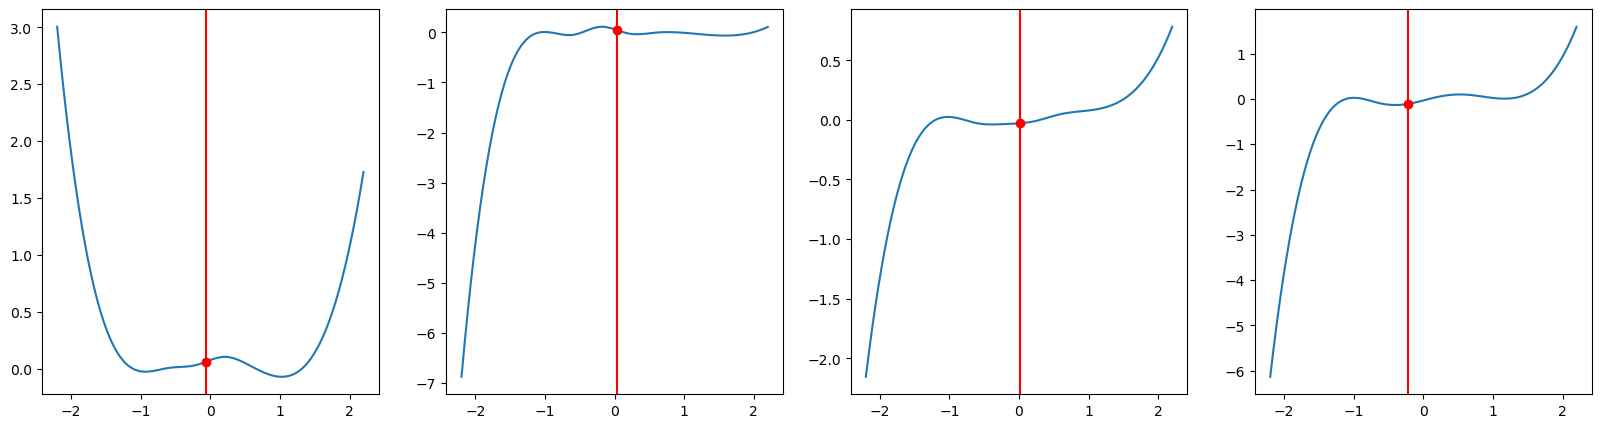

In [9]:
spline_list = model.layers[1].spline_list
num_splines = len(spline_list)

nrows = int(model.layers[1].units)
ncols = int(model.layers[1].input_dim)

# Crea la figura e i sottografici
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 5))
axes = axes.flatten()

w_s_2 = np.array(model.layers[1].scale_factor)
b_act = np.array(model.layers[1].basis_activation(my_record))

layer2_matrix = np.zeros(4)

for i, spline in enumerate(spline_list):
    xx = np.linspace(spline.t[0], spline.t[-1], 100)
    yy = spline(xx)
    axes[i].plot(xx, yy)
    axes[i].axvline(x=sum(layer1_matrix[i]), color='red')
    axes[i].plot(sum(layer1_matrix[i]), spline(sum(layer1_matrix[i])), 'ro')
    layer2_matrix[i] = spline(sum(layer1_matrix[i]))

layer2_matrix = layer2_matrix * w_s_2.T
print(layer2_matrix)
plt.show()

In [10]:
final_result = sum(layer2_matrix[0])
print(f"Output della rete: {final_result}")

Output della rete: 0.0843045109432765
